# Grating Reduced Basis

In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from ngsolve import *
from netgen.geom2d import unit_square


import numpy as np
import scipy
import math
import time
from math import pi

from ngsolve.webgui import Draw
from reduced_basis import *
from netgen.geom2d import *


A nother example to present the reduce basis method is the grating experiment where a wave hits a dense mesh. If the wavelenght $\lambda$ is smaller than the disdence of the mesh then there existst a interference. We colud also set the range of the angle from the interferenc wave with some basic reforming.

\begin{equation}
    n \lambda = d \sin(\alpha)
\end{equation}

where $n = 1$ (number of modes), $d = \frac{1}{s} ($the number of holes of the mesh$)$ and $\lambda = \frac{c2\pi}{\omega}$

\begin{equation}
    \alpha = \arcsin\big(\frac{2\pi s}{\omega}\big)
\end{equation}

In [2]:
def ChebPoints(a,b,n):
    x_i = []
    for i in range(0,n+1):
        fac = (2*i+1)/(2*n+2)
        x_ch = np.cos(pi*fac)
        x_i.append((a+b)/2+((b-a)/2)*x_ch)
    return x_i

In [ ]:
def setang(alpha,d):
    if alpha > 90 or alpha < 30:
        return print("wrong angle")
    return d/(np.sin(np.radians(alpha)))

We could also try to choose some different strategies to choose the snapshots in the range from $\omega$. For example an equidistance snapshots ("equi") or chebichef points snapshots ("Cheb"). 

In [30]:
maxind = 120 # number of snapshots 
mode = "equi" 
s = 40

# set the minimumangle
alpha1 = 30
# set the maxangle
alpha2 = 70

lower = setang(alpha2,s)
upper = setang(alpha1,s)

if mode == "Cheb":
    omegfact = np.sort(ChebPoints(lower,upper,maxind))
if mode == "equi":
    omegfact = np.linspace(lower,upper,maxind)
    
snapshots = []
for i in range(maxind):
    snapshots.append(2*math.pi*omegfact[i])

In [31]:
from netgen.geom2d import *

geo = SplineGeometry()
geo.AddRectangle ( (0,0), (1,1), bcs=["bottom","right","top","left"], leftdomain=1)

n = 40
r = 0.005
for i in range(n-1):
    geo.AddCircle ( (0.5,(i+1)/(n)), r=r, bc="interface", 
                     leftdomain=0, rightdomain=1)
geo.SetMaterial(1, "medium")

mesh = Mesh(geo.GenerateMesh(maxh=0.02))
mesh.Curve(3)
Draw (mesh)

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2007-10-g96d72092', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, …

In [32]:
fes = H1(mesh, order=5, complex=True, dirichlet="interface")
u,v = fes.TnT()
n = { "medium" : 1, "dot" : 3 }
cfn = CoefficientFunction( [n[mat] for mat in mesh.GetMaterials()] )
source = 80*exp(-20**2*(y-0.5)*(y-0.5))*v*ds("left")
space = ReducedBasis(fes, [grad(u)*grad(v)*dx, -1j*u*v *ds("bottom|right|top|left"), -u*v*cfn*cfn *dx], source, snapshots)

compute Reduced Basis for snapshots  [267.45704576991005, 269.4334976926366, 271.40994961536313, 273.3864015380897, 275.3628534608162, 277.3393053835427, 279.31575730626923, 281.2922092289958, 283.26866115172226, 285.24511307444885, 287.2215649971754, 289.1980169199019, 291.1744688426284, 293.15092076535495, 295.12737268808144, 297.103824610808, 299.0802765335345, 301.05672845626106, 303.0331803789876, 305.00963230171413, 306.9860842244407, 308.96253614716716, 310.9389880698937, 312.91543999262024, 314.8918919153468, 316.8683438380733, 318.84479576079985, 320.82124768352634, 322.7976996062529, 324.7741515289794, 326.75060345170596, 328.72705537443244, 330.703507297159, 332.6799592198855, 334.65641114261206, 336.6328630653386, 338.60931498806514, 340.5857669107916, 342.56221883351816, 344.5386707562447, 346.51512267897124, 348.4915746016978, 350.4680265244243, 352.4444784471508, 354.42093036987734, 356.3973822926039, 358.37383421533036, 360.3502861380569, 362.32673806078344, 364.3031899

In [29]:
slider_func1 = lambda alpha: space.draw((2*pi*s)/(np.sin(np.radians(alpha))),redraw=True)
space.draw(space.omega_max,minval = -0.005,maxval = 0.005,autoscale = False)
interact(slider_func1, alpha=widgets.FloatSlider(min=alpha1, max=alpha2, step=1, value=alpha1))

omega: 305.00963230171413, norm of solution: 0.0011381464444452662


NGSWebGuiWidget(value={'ngsolve_version': '6.2.2007-10-g96d72092', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, …

interactive(children=(FloatSlider(value=30.0, description='alpha', max=70.0, min=30.0, step=1.0), Output()), _…

<function __main__.<lambda>(alpha)>

In [19]:
iteration = 1000
if mode == "Cheb":
    snapshots = np.sort(ChebPoints(space.omega_min,space.omega_max,iteration))
    
if mode == "equi":
    snapshots = []
    factor = (space.omega_max-space.omega_min) / iteration
    for i in range(iteration):
        snapshots.append(space.omega_min+factor*i)
    print(snapshots)

 average residual: 0.006764112829157164 
 amount of snapshots: 120


<IPython.core.display.Javascript object>


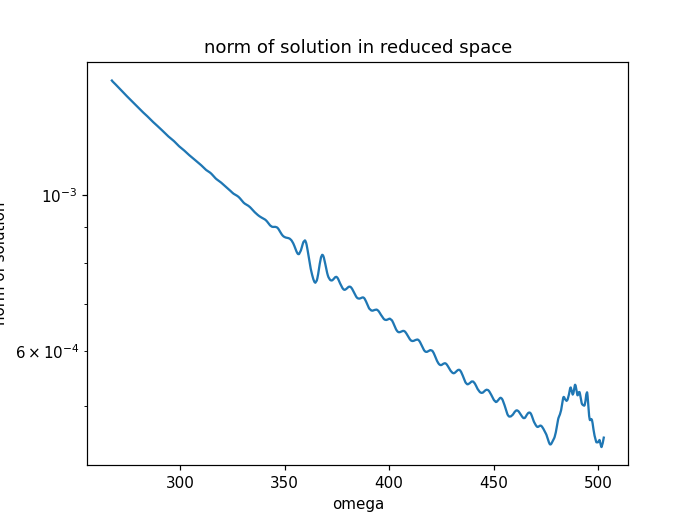

<IPython.core.display.Javascript object>


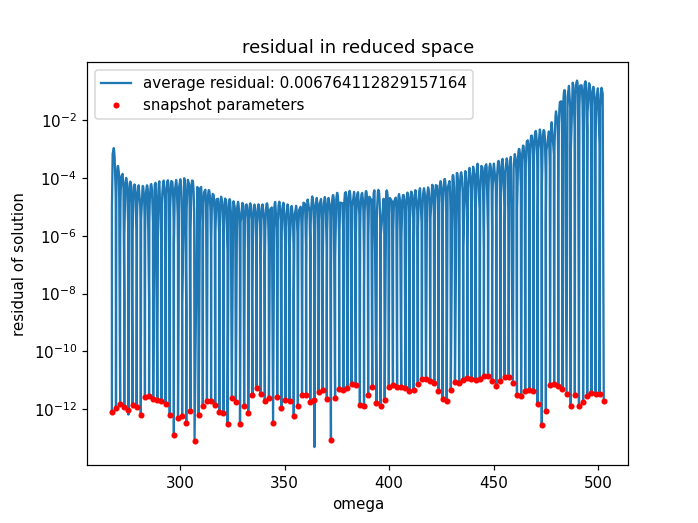

In [18]:
%matplotlib notebook
import matplotlib.pyplot as plt
space.logging = False

norm_omegas, residual_omegas = space.computeValues(snapshots, cheap = True)

print(" average residual: {} \n amount of snapshots: {}".format(np.mean(residual_omegas), len(space.getSnapshots())))

fig, ax = plt.subplots()
ax.plot(snapshots, norm_omegas,  '-', label = "norm")
ax.set_xlabel("omega")
ax.set_ylabel("norm of solution")
ax.set_title("norm of solution in reduced space")
plt.semilogy()
plt.savefig("norm of solution in reduced space {} {}".format(mode,maxind))

fig, ax = plt.subplots()         
ax.plot(snapshots, residual_omegas , '-',label = "average residual: {}".format(np.mean(residual_omegas)))
sn_residual = space.computeValues(space.getSnapshots(), norm= False, cheap = True)
ax.plot(space.getSnapshots(), sn_residual, 'r.', label = "snapshot parameters")
ax.legend()
ax.set_xlabel("omega")
ax.set_ylabel('residual of solution')
ax.set_title("residual in reduced space")
plt.semilogy()
plt.savefig("residual in reduced space {} {}".format(mode,maxind))